In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
from glob import glob
import h5py
from tqdm import tqdm
import pandas as pd

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('../keras_network/')
sys.path.append('../data_processing/')
from data_generator import DataGenerator

In [3]:
from losses import metrics
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)

In [4]:
from preprocess_aqua import L_V, C_P, conversion_dict

In [5]:
model_path = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/keras_network/models/000_test.h5.h5'

In [6]:
data_dir = '/beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05_old/'

In [7]:
pre_dir = '/beegfs/DATA/pritchard/srasp/preprocessed_data/'

In [8]:
range_dict = {
    'SPDT' : [-5e-4, 5e-4],
    'SPDQ' : [-5e-7, 5e-7],
    'QRL' : [-2e-4, 2e-4],
    'QRS' : [-1.2e-4, 1.2e-4]
}

In [138]:
class ModelDiagnostics(object):
    """
    TODO:
    - colorbar
    - x-y labels
    """
    def __init__(self, model_path, keras_features_fn, keras_targets_fn, keras_norm_fn,
                 nlat=64, nlon=128, nlev=30):
        """
        keras_features [sample, input_z]
        keras_targets [sample, output_z]
        """
        self.model_path = model_path
        self.model = self.load_model()
        self.keras_features_fn = keras_features_fn
        self.keras_targets_fn = keras_targets_fn
        self.keras_norm_fn = keras_norm_fn
        self.keras_features = h5py.File(keras_features_fn, 'r')
        self.keras_targets = h5py.File(keras_targets_fn, 'r')
        self.keras_norm = h5py.File(keras_norm_fn, 'r')
        self.nlat = nlat; self.nlon = nlon
        self.ngeo = nlat * nlon
        self.nlev = nlev
        self.feature_vars, self.target_vars = self.get_var_names()
        self.unscale_arr = self.get_unscale_arr()
        
    def load_model(self):
        # For keras model
        return keras.models.load_model(self.model_path)
    #def get_files(self):
    #    return sorted(glob(self.data_dir + self.aqua_pref + '*'))
    
    def get_var_names(self):
        """
        Return unique variable names for features and targets in correct order.
        """
        return [
            list(dict.fromkeys(
                [f.split('_lev')[0] for f in list(self.keras_norm[f'{a}_names'][:])]
            )) for a in ['feature', 'target']
        ]
    
    def get_unscale_arr(self):
        """
        Returns an array of size z_output to unscale the entire output array
        """
        return np.array([
            conversion_dict[v.split('_lev')[0]] for v in list(self.keras_norm['target_names'])
        ])
    
    def plot_double_lat_lev_slice(self, var, itime, ilon):
        # Get actual values
        #true = xr.open_dataset(
        #    self.aqua_files[idate], decode_times=False)[var].isel(time=itime, lon=ilon)
        
        # Get predictions and true values. THIS WILL BE DIFFERENT FOR TF
        preds, true = self.get_preds_and_truth(var, itime)
        preds = preds[:, ilon, :]; true = true[:, ilon, :]
        self.plot_double_slice(preds.T, true.T, var)
        
    def plot_double_lat_lon_slice(self, var, itime, ilev):
        # Get predictions and true values. THIS WILL BE DIFFERENT FOR TF
        preds, true = self.get_preds_and_truth(var, itime)
        preds = preds[:, :, ilev]; true = true[:, :, ilev]
        self.plot_double_slice(preds, true, var)
        
    def plot_double_slice(self, p, t, var=None):
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        if var is None: mn = None; mx = None
        else: mn=range_dict[var][0], mx=range_dict[var][1]
        axes[0].imshow(p, vmin=mn, vmax=mx, cmap='bwr')
        axes[1].imshow(t, vmin=mn, vmax=mx, cmap='bwr')
        axes[0].set_title('CBRAIN Predictions')
        axes[1].set_title('SP-CAM Truth')
        plt.show()
        
    def plot_slice(self, x, title, **kwargs):
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax.imshow(x, **kwargs)
        ax.set_title(title)
        plt.show()
        
    def get_preds_and_truth(self, var, itime):
        f = self.keras_features['features'][itime*self.ngeo:(itime+1)*self.ngeo]
        p = self.model.predict_on_batch(f)
        t = self.keras_targets['targets'][itime*self.ngeo:(itime+1)*self.ngeo]
        return self.reshape_output(p, var), self.reshape_output(t, var)
    
    def reshape_output(self, x, var=None, unscale=True):
        """
        Assumes [sample, z] for one time step
        """
        x = x.reshape(self.nlat, self.nlon, x.shape[-1]) # [lat, lon, z]
        if var is None: var_idxs = slice(0, None, 1)
        else:
            var_idxs = [
                i for i, s in enumerate(list(self.keras_targets['target_names'][:])) 
                if var in s]
        x = x[:, :, var_idxs]
        # Unscale
        if unscale: x /= conversion_dict[var]
        return x
    
    def compute_stats(self):
        """
        Compute statistics over entire dataset [lat, lon, lev].
        bias = mean(preds) - mean(true)
        mse = sse(preds, true) / n_samples
        rel_mse = mse / std(true)
        std_error = std(preds) - std(true)
        """
        # Get data generator without shuffling!
        gen_obj = DataGenerator(
            '/',
            self.keras_features_fn,
            self.keras_targets_fn,
            shuffle=False,
            batch_size=self.ngeo,   # time step sized batches
            verbose=True,
        )
        gen = gen_obj.return_generator()
        psum = np.zeros((self.ngeo, gen_obj.target_shape))
        tsum = np.copy(psum); sse = np.copy(psum)
        psqsum = np.copy(psum); tsqsum = np.copy(psum)
        #for t in tqdm(range(gen_obj.n_batches)):  # Every batch is one time step!
        for t in tqdm(range(25)):
            # Load features and targets
            f, t = next(gen)
            # Get predictions
            p = self.model.predict_on_batch(f)   # [ngeo samples, z]
            # Unscale outputs at this level
            p /= self.unscale_arr; t /= self.unscale_arr
            # Compute statistics
            psum += p; tsum += t
            psqsum += p**2; tsqsum += t**2
            sse += (t - p) ** 2
        
        # Compute average statistics
        self.stats_dict = {}
        n = gen_obj.n_batches
        pmean = psum / n; tmean = tsum / n
        self.bias = pmean - tmean; self.stats_dict['bias'] = self.bias
        self.mse = sse / n; self.stats_dict['mse'] = self.mse
        self.pred_var = psqsum / n - pmean**2; self.stats_dict['pred_var'] = self.pred_var
        self.true_var = tsqsum / n - tmean**2; self.stats_dict['true_var'] = self.true_var
        
    def mean_stats(self, cutoff_level=9):
        expl_var_str = f'expl_var_cut{cutoff_level}'
        df = pd.DataFrame(
            index=self.target_vars + ['all'], 
            columns=list(self.stats_dict.keys()) + [expl_var_str])
        # Compute statistics for each variable
        for var in self.target_vars + ['all']:
            for stat_name, stat in self.stats_dict.items():
                
                df.loc[var, stat_name] = np.mean(self.reshape_output(
                    stat, var=None if var == 'all' else var, unscale=False))
                
                df.loc[var, expl_var_str] = np.mean((
                    np.mean(self.reshape_output(self.mse, var, unscale=False), axis=(0, 1)) /
                    np.mean(self.reshape_output(self.true_var, var, unscale=False), axis=(0, 1))
                ).reshape(self.nlev, -1)[cutoff_level:])
        return df
    
    def plot_stat_lat_lev_mean(self, stat_name, var, **kwargs):
        arr = np.mean(diag.reshape_output(self.stats_dict[stat_name], var=var), axis=1).T
        self.plot_slice(arr, var + ' ' + stat_name, **kwargs)

In [139]:
diag = ModelDiagnostics(
    model_path, 
    pre_dir + 'pure_crm_essentials_valid_month02_features.nc',
    pre_dir + 'pure_crm_essentials_valid_month02_targets.nc',
    pre_dir + 'pure_crm_essentials_train_month01_norm.nc'
)

In [140]:
diag.compute_stats()

  4%|▍         | 1/25 [00:00<00:04,  5.69it/s]

Generator will have 11001856 samples in 1343 batches
Features have shape 152; targets have shape 120


100%|██████████| 25/25 [00:01<00:00, 21.26it/s]


In [141]:
df = diag.mean_stats()

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in true_divide
/export/home/srasp/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/export/home/srasp/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [142]:
df

,bias,mse,pred_var,true_var,expl_var_cut9
SPDQ,1.21952e-11,2.52916e-17,5.01437e-17,7.94731e-17,0.608872
SPDT,-2.09592e-08,2.12752e-11,2.75545e-11,5.15512e-11,0.537834
QRL,2.05558e-08,3.97261e-12,7.50611e-12,1.23918e-11,0.38306
QRS,-9.51193e-09,7.1194e-13,5.87982e-12,6.92442e-12,0.277014
all,-2.47578e-09,6.48993e-12,1.02351e-11,1.77169e-11,NaN


In [121]:
a = np.ones((10, 30)); b=np.arange(30)

In [125]:
c = a / b

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [126]:
c[0]

array([        inf,  1.        ,  0.5       ,  0.33333333,  0.25      ,
        0.2       ,  0.16666667,  0.14285714,  0.125     ,  0.11111111,
        0.1       ,  0.09090909,  0.08333333,  0.07692308,  0.07142857,
        0.06666667,  0.0625    ,  0.05882353,  0.05555556,  0.05263158,
        0.05      ,  0.04761905,  0.04545455,  0.04347826,  0.04166667,
        0.04      ,  0.03846154,  0.03703704,  0.03571429,  0.03448276])

In [127]:
c[1]

array([        inf,  1.        ,  0.5       ,  0.33333333,  0.25      ,
        0.2       ,  0.16666667,  0.14285714,  0.125     ,  0.11111111,
        0.1       ,  0.09090909,  0.08333333,  0.07692308,  0.07142857,
        0.06666667,  0.0625    ,  0.05882353,  0.05555556,  0.05263158,
        0.05      ,  0.04761905,  0.04545455,  0.04347826,  0.04166667,
        0.04      ,  0.03846154,  0.03703704,  0.03571429,  0.03448276])

In [84]:
df

,bias,mse,pred_var,true_var,rel_mse
SPDQ,1.21952e-11,6.32291e-11,1.25359e-10,1.98683e-10,inf
SPDT,-2.09592e-08,2.12752e-08,2.75545e-08,5.15512e-08,inf
QRL,2.05558e-08,3.97261e-09,7.50611e-09,1.23918e-08,0.00359469
QRS,-9.51193e-09,7.1194e-10,5.87982e-09,6.92442e-09,inf


In [85]:
diag.mse.shape

(8192, 120)

In [86]:
tmp = diag.reshape_output(diag.mse, 'SPDT'); tmp.shape

(64, 128, 30)

In [87]:
tmp = np.mean(tmp, axis=(0, 1)); tmp.shape

(30,)

In [89]:
tmp2 = np.mean(diag.reshape_output(diag.true_var, 'SPDT'), axis=(0, 1))

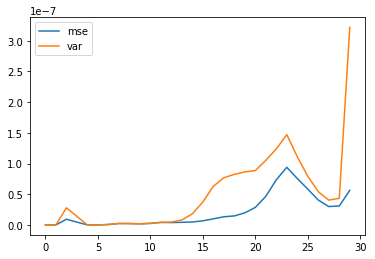

In [92]:
plt.plot(tmp, label='mse')
plt.plot(tmp2, label='var')
plt.legend();

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


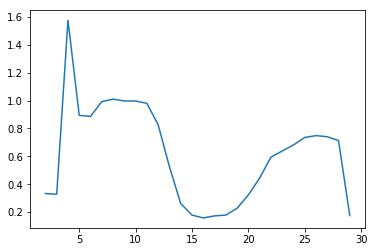

In [93]:
ratio = tmp / tmp2; plt.plot(ratio);

In [98]:
ratio

array([        inf,         inf,  0.3329483 ,  0.32784795,  1.57669811,
        0.89392736,  0.88623176,  0.99294329,  1.01037783,  0.99740478,
        0.99697156,  0.98022808,  0.8266022 ,  0.52649013,  0.26136813,
        0.17839391,  0.15787975,  0.17242366,  0.17809579,  0.22729305,
        0.32258424,  0.44314872,  0.59341007,  0.63816631,  0.6814138 ,
        0.73513369,  0.74854114,  0.7408195 ,  0.71333303,  0.17482155])

In [102]:
1 - np.mean(ratio[9:])

0.46216556709404877

In [61]:
np.square(df.loc['SPDT', 'rmse']) / df.loc['SPDT', 'true_var']

0.00011590491809845584

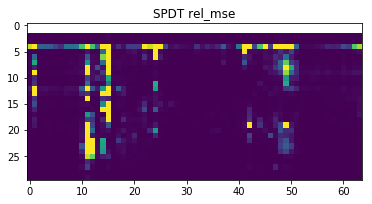

In [66]:
diag.plot_stat_lat_lev_mean('rel_mse', 'SPDT', vmin=0, vmax=0.5)

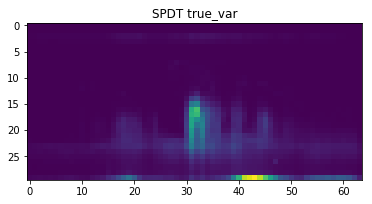

In [65]:
diag.plot_stat_lat_lev_mean('true_var', 'SPDT')

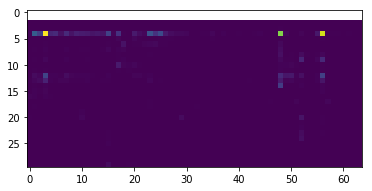

In [18]:
plt.imshow(diag.reshape_output(diag.rel_mse, var='SPDT')[:, 0, :].T)

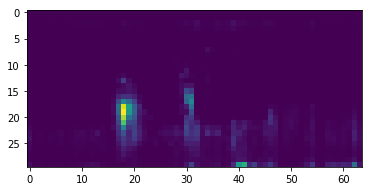

In [19]:
plt.imshow(diag.reshape_output(diag.true_var, var='SPDT')[:, 0, :].T)

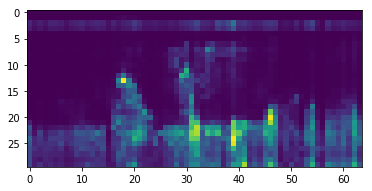

In [49]:
plt.imshow(diag.reshape_output(diag.rmse, var='SPDT')[:, 0, :].T)

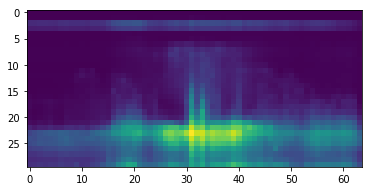

In [50]:
plt.imshow(np.mean(diag.reshape_output(diag.rmse, var='SPDT'), axis=1).T)

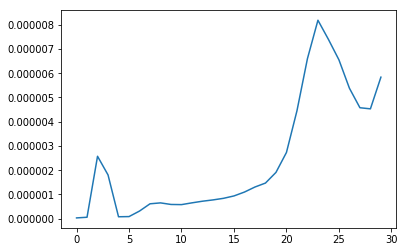

In [51]:
plt.plot(np.mean(diag.reshape_output(diag.rmse, var='SPDT'), axis=(0,1)))

In [52]:
np.mean(diag.reshape_output(diag.rmse, var='SPDT'))

2.4443889655356344e-06

In [56]:
l = ['a', 'b']
v = [3, 4]

In [86]:
p = pd.DataFrame()

In [62]:
p

""


In [63]:
p['a'] = [3]

In [64]:
p

,a
0,3


In [105]:
diag.stats_dict.keys()

dict_keys(['bias', 'rmse', 'pred_var', 'true_var'])

In [106]:
p = pd.DataFrame(index=diag.feature_vars, columns=diag.stats_dict.keys())

In [107]:
p

,bias,rmse,pred_var,true_var
T_C,NaN,NaN,NaN,NaN
Q_C,NaN,NaN,NaN,NaN
V_C,NaN,NaN,NaN,NaN
dTdt_adiabatic,NaN,NaN,NaN,NaN
dQdt_adiabatic,NaN,NaN,NaN,NaN
PS,NaN,NaN,NaN,NaN
SOLIN,NaN,NaN,NaN,NaN


In [95]:
p['a'] = [1, 2, 3, 4,5, 6, 7]

In [96]:
p

,a
T_C,1
Q_C,2
V_C,3
dTdt_adiabatic,4
dQdt_adiabatic,5
PS,6
SOLIN,7


In [102]:
p.loc['T_C', 'a']

1